# this project is powered by verimake

In [193]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 22 11:12:29 2017

@author: juliette
"""

#######################################################################
# jade.py -- Blind source separation of real signals
#
# Version 1.8
#
# Copyright 2005, Jean-Francois Cardoso (Original MATLAB code)
# Copyright 2007, Gabriel J.L. Beckers (NumPy translation)
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#######################################################################

"""
jade

This module contains only one function, jadeR, which does blind source
separation of real signals. Hopefully more ICA algorithms will be added in the
future.
"""

from sys import stdout 
from numpy import abs, append, arange, arctan2, argsort, array, concatenate, \
    cos, diag, dot, eye, float32, float64, matrix, multiply, ndarray, newaxis, \
    sign, sin, sqrt, zeros
from numpy.linalg import eig, pinv


def jadeR(X, m=None, verbose=True):
    """
    Blind separation of real signals with JADE.
    
    jadeR implements JADE, an Independent Component Analysis (ICA) algorithm
    developed by Jean-Francois Cardoso. See
    http://www.tsi.enst.fr/~cardoso/guidesepsou.html , and papers cited
    at the end of the source file.
        
    Translated into NumPy from the original Matlab Version 1.8 (May 2005) by
    Gabriel Beckers, http://gbeckers.nl .
    
    Parameters:
    
        X -- an nxT data matrix (n sensors, T samples). May be a numpy array or
             matrix.
    
        m -- output matrix B has size mxn so that only m sources are
             extracted.  This is done by restricting the operation of jadeR
             to the m first principal components. Defaults to None, in which
             case m=n.
        
        verbose -- print info on progress. Default is True.
    
    Returns:
    
        An m*n matrix B (NumPy matrix type), such that Y=B*X are separated
        sources extracted from the n*T data matrix X. If m is omitted, B is a
        square n*n matrix (as many sources as sensors). The rows of B are
        ordered such that the columns of pinv(B) are in order of decreasing
        norm; this has the effect that the `most energetically significant`
        components appear first in the rows of Y=B*X.
    
    Quick notes (more at the end of this file):
    
    o This code is for REAL-valued signals.  A MATLAB implementation of JADE
        for both real and complex signals is also available from
        http://sig.enst.fr/~cardoso/stuff.html
    
    o This algorithm differs from the first released implementations of
        JADE in that it has been optimized to deal more efficiently
        1) with real signals (as opposed to complex)
        2) with the case when the ICA model does not necessarily hold.
    
    o There is a practical limit to the number of independent
        components that can be extracted with this implementation.  Note
        that the first step of JADE amounts to a PCA with dimensionality
        reduction from n to m (which defaults to n).  In practice m
        cannot be `very large` (more than 40, 50, 60... depending on
        available memory)
    
    o See more notes, references and revision history at the end of
        this file and more stuff on the WEB
        http://sig.enst.fr/~cardoso/stuff.html
    
    o For more info on NumPy translation, see the end of this file.
    
    o This code is supposed to do a good job!  Please report any
        problem relating to the NumPY code gabriel@gbeckers.nl
    
    Copyright original Matlab code : Jean-Francois Cardoso <cardoso@sig.enst.fr>
    Copyright Numpy translation : Gabriel Beckers <gabriel@gbeckers.nl>
    """
    
    # GB: we do some checking of the input arguments and copy data to new
    # variables to avoid messing with the original input. We also require double
    # precision (float64) and a numpy matrix type for X.
    
    assert isinstance(X, ndarray),\
        "X (input data matrix) is of the wrong type (%s)" % type(X)
    origtype = X.dtype # remember to return matrix B of the same type
    X = matrix(X.astype(float64))
    assert X.ndim == 2, "X has %d dimensions, should be 2" % X.ndim
    assert (verbose == True) or (verbose == False), \
        "verbose parameter should be either True or False"

    [n,T] = X.shape # GB: n is number of input signals, T is number of samples
    
    if m==None:
        m=n 	# Number of sources defaults to # of sensors
    assert m<=n,\
        "jade -> Do not ask more sources (%d) than sensors (%d )here!!!" % (m,n)

    if verbose:
        print ("jade -> Looking for %d sources" % m)
        print ( "jade -> Removing the mean value")
    X -= X.mean(1)
    
    # whitening & projection onto signal subspace
    # ===========================================
    if verbose:
        print ("jade -> Whitening the data")
    [D,U] = eig((X * X.T) / float(T)) # An eigen basis for the sample covariance matrix
    k = D.argsort()
    Ds = D[k] # Sort by increasing variances
    PCs = arange(n-1, n-m-1, -1)    # The m most significant princip. comp. by decreasing variance

    # --- PCA  ----------------------------------------------------------
    B = U[:,k[PCs]].T    # % At this stage, B does the PCA on m components
    
    # --- Scaling  ------------------------------------------------------
    scales = sqrt(Ds[PCs]) # The scales of the principal components .
    B = diag(1./scales) * B  # Now, B does PCA followed by a rescaling = sphering
    #B[-1,:] = -B[-1,:] # GB: to make it compatible with octave
    # --- Sphering ------------------------------------------------------
    X = B * X # %% We have done the easy part: B is a whitening matrix and X is white.
    
    del U, D, Ds, k, PCs, scales 
    
    # NOTE: At this stage, X is a PCA analysis in m components of the real data, except that
    # all its entries now have unit variance.  Any further rotation of X will preserve the
    # property that X is a vector of uncorrelated components.  It remains to find the
    # rotation matrix such that the entries of X are not only uncorrelated but also `as
    # independent as possible".  This independence is measured by correlations of order
    # higher than 2.  We have defined such a measure of independence which
    #   1) is a reasonable approximation of the mutual information
    #   2) can be optimized by a `fast algorithm"
    # This measure of independence also corresponds to the `diagonality" of a set of
    # cumulant matrices.  The code below finds the `missing rotation " as the matrix which
    # best diagonalizes a particular set of cumulant matrices.
    
    
    # Estimation of the cumulant matrices.
    # ====================================
    if verbose:
        print ("jade -> Estimating cumulant matrices")
    
    # Reshaping of the data, hoping to speed up things a little bit...
    X = X.T
    dimsymm = int((m * ( m + 1)) / 2)	# Dim. of the space of real symm matrices
    nbcm = dimsymm  # number of cumulant matrices
    CM = matrix(zeros([m,m*nbcm], dtype=float64)) # Storage for cumulant matrices
    R = matrix(eye(m, dtype=float64))
    Qij = matrix(zeros([m,m], dtype=float64)) # Temp for a cum. matrix
    Xim	= zeros(m, dtype=float64) # Temp
    Xijm = zeros(m, dtype=float64) # Temp
    #Uns = numpy.ones([1,m], dtype=numpy.uint32)    # for convenience
    # GB: we don't translate that one because NumPy doesn't need Tony's rule
    
    # I am using a symmetry trick to save storage.  I should write a short note one of these
    # days explaining what is going on here.
    Range = arange(m) # will index the columns of CM where to store the cum. mats.
    
    for im in range(m):
        Xim = X[:,im]
        Xijm = multiply(Xim, Xim)
        # Note to myself: the -R on next line can be removed: it does not affect
        # the joint diagonalization criterion
        Qij = multiply(Xijm, X).T * X / float(T)\
            - R - 2 * dot(R[:,im], R[:,im].T)
        CM[:,Range] = Qij 
        Range = Range  + m 
        for jm in range(im):
            Xijm = multiply(Xim, X[:,jm])
            Qij = sqrt(2) * multiply(Xijm, X).T * X / float(T) \
                - R[:,im] * R[:,jm].T - R[:,jm] * R[:,im].T
            CM[:,Range]	= Qij
            Range = Range + m

    # Now we have nbcm = m(m+1)/2 cumulants matrices stored in a big m x m*nbcm array.
   
    V = matrix(eye(m, dtype=float64))
        
    Diag = zeros(m, dtype=float64)
    On = 0.0
    Range = arange(m)
    for im in range(nbcm):
        Diag = diag(CM[:,Range])
        On = On + (Diag*Diag).sum(axis=0)
        Range = Range + m
    Off = (multiply(CM,CM).sum(axis=0)).sum(axis=0) - On
    
    seuil = 1.0e-6 / sqrt(T) # % A statistically scaled threshold on `small" angles
    encore = True
    sweep = 0 # % sweep number
    updates = 0 # % Total number of rotations
    upds = 0 # % Number of rotations in a given seep
    g = zeros([2,nbcm], dtype=float64)
    gg = zeros([2,2], dtype=float64)
    G = zeros([2,2], dtype=float64)
    c = 0
    s = 0
    ton	= 0
    toff = 0
    theta = 0
    Gain = 0
    
    # Joint diagonalization proper
    
    if verbose:
        print ( "jade -> Contrast optimization by joint diagonalization")
    
    while encore:
        encore = False
        if verbose:
            print("jade -> Sweep #%3d" % sweep)
        sweep = sweep + 1
        upds  = 0
        Vkeep = V
      
        for p in range(m-1):
            for q in range(p+1, m):
                
                Ip = arange(p, m*nbcm, m)
                Iq = arange(q, m*nbcm, m)
                
                # computation of Givens angle
                g = concatenate([CM[p,Ip] - CM[q,Iq], CM[p,Iq] + CM[q,Ip]])
                gg = dot(g, g.T)
                ton = gg[0,0] - gg[1,1] 
                toff = gg[0,1] + gg[1,0]
                theta = 0.5 * arctan2(toff, ton + sqrt(ton * ton + toff * toff))
                Gain = (sqrt(ton * ton + toff * toff) - ton) / 4.0
                
                # Givens update
                if abs(theta) > seuil:
                    encore = True
                    upds = upds + 1
                    c = cos(theta) 
                    s = sin(theta)
                    G = matrix([[c, -s] , [s, c] ])
                    pair = array([p,q])
                    V[:,pair] = V[:,pair] * G
                    CM[pair,:] = G.T * CM[pair,:]
                    CM[:,concatenate([Ip,Iq])] = \
                        append( c*CM[:,Ip]+s*CM[:,Iq], -s*CM[:,Ip]+c*CM[:,Iq], \
                               axis=1)
                    On = On + Gain
                    Off = Off - Gain
                    
        if verbose:
            print ( "completed in %d rotations" % upds)
        updates = updates + upds
    if verbose:
        print ("jade -> Total of %d Givens rotations" % updates)
    
    # A separating matrix
    # ===================
    
    B = V.T * B
    
    # Permute the rows of the separating matrix B to get the most energetic components first.
    # Here the **signals** are normalized to unit variance.  Therefore, the sort is
    # according to the norm of the columns of A = pinv(B)

    if verbose:
        print("jade -> Sorting the components")
    
    A = pinv(B)
    keys =  array(argsort(multiply(A,A).sum(axis=0)[0]))[0]
    B = B[keys,:]
    B = B[::-1,:]     # % Is this smart ?
    
    
    if verbose:
        print ("jade -> Fixing the signs")
    b	= B[:,0]
    signs = array(sign(sign(b)+0.1).T)[0] # just a trick to deal with sign=0
    B = diag(signs) * B
    
    return B.astype(origtype)
    
    
    # Revision history of MATLAB code:
    #
    #- V1.8, May 2005
    #  - Added some commented code to explain the cumulant computation tricks.
    #  - Added reference to the Neural Comp. paper.
    #
    #-  V1.7, Nov. 16, 2002
    #   - Reverted the mean removal code to an earlier version (not using 
    #     repmat) to keep the code octave-compatible.  Now less efficient,
    #     but does not make any significant difference wrt the total 
    #     computing cost.
    #   - Remove some cruft (some debugging figures were created.  What 
    #     was this stuff doing there???)
    #
    #
    #-  V1.6, Feb. 24, 1997 
    #   - Mean removal is better implemented.
    #   - Transposing X before computing the cumulants: small speed-up
    #   - Still more comments to emphasize the relationship to PCA
    #
    #-  V1.5, Dec. 24 1997 
    #   - The sign of each row of B is determined by letting the first element be positive.
    #
    #-  V1.4, Dec. 23 1997 
    #   - Minor clean up.
    #   - Added a verbose switch
    #   - Added the sorting of the rows of B in order to fix in some reasonable way the
    #     permutation indetermination.  See note 2) below.
    #
    #-  V1.3, Nov.  2 1997 
    #   - Some clean up.  Released in the public domain.
    #
    #-  V1.2, Oct.  5 1997 
    #   - Changed random picking of the cumulant matrix used for initialization to a
    #     deterministic choice.  This is not because of a better rationale but to make the
    #     ouput (almost surely) deterministic.
    #   - Rewrote the joint diag. to take more advantage of Matlab"s tricks.
    #   - Created more dummy variables to combat Matlab"s loose memory management.
    #
    #-  V1.1, Oct. 29 1997.
    #    Made the estimation of the cumulant matrices more regular. This also corrects a
    #    buglet...
    #
    #-  V1.0, Sept. 9 1997. Created.
    #
    # Main references:
    # @article{CS-iee-94,
    #  title 	= "Blind beamforming for non {G}aussian signals",
    #  author       = "Jean-Fran\c{c}ois Cardoso and Antoine Souloumiac",
    #  HTML 	= "ftp://sig.enst.fr/pub/jfc/Papers/iee.ps.gz",
    #  journal      = "IEE Proceedings-F",
    #  month = dec, number = 6, pages = {362-370}, volume = 140, year = 1993}
    #
    #
    #@article{JADE:NC,
    #  author  = "Jean-Fran\c{c}ois Cardoso",
    #  journal = "Neural Computation",
    #  title   = "High-order contrasts for independent component analysis",
    #  HTML    = "http://www.tsi.enst.fr/~cardoso/Papers.PS/neuralcomp_2ppf.ps",
    #  year    = 1999, month =	jan,  volume =	 11,  number =	 1,  pages =	 "157-192"}
    #
    #
    #  Notes:
    #  ======
    #
    #  Note 1) The original Jade algorithm/code deals with complex signals in Gaussian noise
    #  white and exploits an underlying assumption that the model of independent components
    #  actually holds.  This is a reasonable assumption when dealing with some narrowband
    #  signals.  In this context, one may i) seriously consider dealing precisely with the
    #  noise in the whitening process and ii) expect to use the small number of significant
    #  eigenmatrices to efficiently summarize all the 4th-order information.  All this is done
    #  in the JADE algorithm.
    #
    #  In *this* implementation, we deal with real-valued signals and we do NOT expect the ICA
    #  model to hold exactly.  Therefore, it is pointless to try to deal precisely with the
    #  additive noise and it is very unlikely that the cumulant tensor can be accurately
    #  summarized by its first n eigen-matrices.  Therefore, we consider the joint
    #  diagonalization of the *whole* set of eigen-matrices.  However, in such a case, it is
    #  not necessary to compute the eigenmatrices at all because one may equivalently use
    #  `parallel slices" of the cumulant tensor.  This part (computing the eigen-matrices) of
    #  the computation can be saved: it suffices to jointly diagonalize a set of cumulant
    #  matrices.  Also, since we are dealing with reals signals, it becomes easier to exploit
    #  the symmetries of the cumulants to further reduce the number of matrices to be
    #  diagonalized.  These considerations, together with other cheap tricks lead to this
    #  version of JADE which is optimized (again) to deal with real mixtures and to work
    #  `outside the model'.  As the original JADE algorithm, it works by minimizing a `good
    #  set' of cumulants.
    #
    #  Note 2) The rows of the separating matrix B are resorted in such a way that the columns
    #  of the corresponding mixing matrix A=pinv(B) are in decreasing order of (Euclidian)
    #  norm.  This is a simple, `almost canonical" way of fixing the indetermination of
    #  permutation.  It has the effect that the first rows of the recovered signals (ie the
    #  first rows of B*X) correspond to the most energetic *components*.  Recall however that
    #  the source signals in S=B*X have unit variance.  Therefore, when we say that the
    #  observations are unmixed in order of decreasing energy, this energetic signature is to
    #  be found as the norm of the columns of A=pinv(B) and not as the variances of the
    #  separated source signals.
    #
    #  Note 3) In experiments where JADE is run as B=jadeR(X,m) with m varying in range of
    #  values, it is nice to be able to test the stability of the decomposition.  In order to
    #  help in such a test, the rows of B can be sorted as described above. We have also
    #  decided to fix the sign of each row in some arbitrary but fixed way.  The convention is
    #  that the first element of each row of B is positive.
    #
    #  Note 4) Contrary to many other ICA algorithms, JADE (or least this version) does not
    #  operate on the data themselves but on a statistic (the full set of 4th order cumulant).
    #  This is represented by the matrix CM below, whose size grows as m^2 x m^2 where m is
    #  the number of sources to be extracted (m could be much smaller than n).  As a
    #  consequence, (this version of) JADE will probably choke on a `large' number of sources.
    #  Here `large' depends mainly on the available memory and could be something like 40 or
    #  so.  One of these days, I will prepare a version of JADE taking the `data' option
    #  rather than the `statistic' option.
    
    # Notes on translation (GB):
    # =========================
    #
    # Note 1) The function jadeR is a relatively literal translation from the original MATLAB
    # code. I haven't really looked into optimizing it for NumPy. If you have any time to look
    # at this and good ideas, let me know.
    #
    # Note 2) A test module that compares NumPy output with Octave (MATLAB
    # clone) output of the original MATLAB script is available

## data input

In [4]:
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

path="C:\\Users\\yexue\\PycharmProjects\\webcamHR"
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
result

['Webcam-pulse2020-09-24 06_33_29_156888.csv',
 'Webcam-pulse2020-09-24 06_33_35_102433.csv',
 'Webcam-pulse2020-09-24 06_33_42_447528.csv',
 'Webcam-pulse2020-09-24 06_33_49_125135.csv',
 'Webcam-pulse2020-09-25 23_27_23_265066.csv',
 'Webcam-pulse2020-09-25 23_27_31_862311.csv',
 'Webcam-pulse2020-09-25 23_27_47_855041.csv',
 'Webcam-pulse2020-09-25 23_29_20_171984.csv',
 'Webcam-pulse2020-09-25 23_29_22_005542.csv',
 'Webcam-pulse2020-09-25 23_29_29_301034.csv',
 'Webcam-pulse2020-09-27 14_53_49_300513.csv',
 'Webcam-pulse2020-09-27 14_54_04_649572.csv',
 'Webcam-pulse2020-09-27 14_55_13_030050.csv',
 'Webcam-pulse2020-09-27 22_24_51_579371.csv',
 'Webcam-pulse2020-09-30 13_01_38_442205.csv',
 'Webcam-pulse2020-09-30 13_01_45_189784.csv',
 'Webcam-pulse2020-09-30 13_01_56_042280.csv',
 'Webcam-pulse2020-09-30 13_02_26_603889.csv',
 'Webcam-pulse2020-09-30 13_06_30_775515.csv',
 'Webcam-pulse2020-09-30 13_06_50_634852.csv',
 'Webcam-pulse2020-09-30 13_06_59_501874.csv',
 'Webcam-puls

In [205]:
data=np.loadtxt(os.path.join(path,result[4]),delimiter=",").transpose()
print(data.shape)
X=data[1:]

(4, 250)


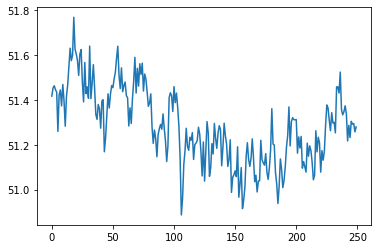

In [206]:
plt.plot(X[0])

## check the original signal

(250,)
21
2.524116671912802


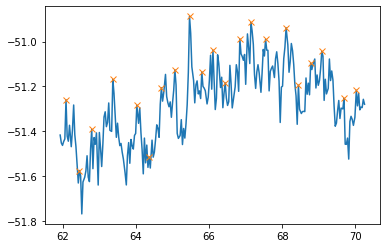

In [207]:
from scipy.signal import find_peaks

X_mean = np.mean(X, axis=0)
print(X_mean.shape)
# peaks, _ = find_peaks(X_mean, height=0,  distance=3)
# plt.plot(data[0], X_mean)
# plt.plot(data[0][peaks], X_mean[peaks], "x")
Y=-X
peaks, _ = find_peaks(Y[0],  distance=9)
plt.plot(data[0], Y[0])
plt.plot(data[0][peaks], Y[0][peaks], "x")

duration = data[0][-1]-data[0][0]
peak_num = len(peaks)
peak_rate = peak_num/duration
print(peak_num)
print(peak_rate)

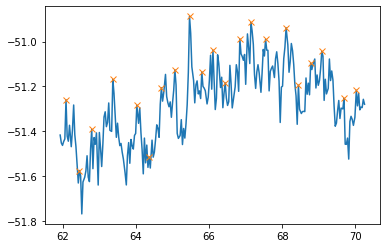

21
2.524116671912802


In [208]:
def count_peaks(Y=-X[0],dist=9,plot=True):
    peaks, _ = find_peaks(Y,  distance=9)
    if plot:
        plt.plot(data[0], Y)
        plt.plot(data[0][peaks], Y[peaks], "x")
        plt.show()

    duration = data[0][-1]-data[0][0]
    peak_num = len(peaks)
    peak_rate = peak_num/duration
    print(peak_num)
    print(peak_rate)
    
count_peaks()

## JADE_R

In [209]:
def processing_jade(data):
    X=data[1:]
    X_transformed = jadeR(X, m=3, verbose=False)
    # X_ = np.matmul(np.linalg.inv(X_transformed), self.samples)
    X_ = np.matmul(X_transformed, X)
    # X_ = self.samples
    X_ = np.array(X_)
    return X_

before JADE...


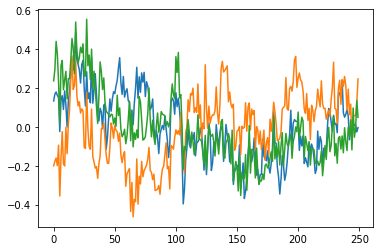

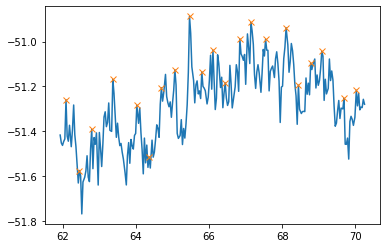

21
2.524116671912802


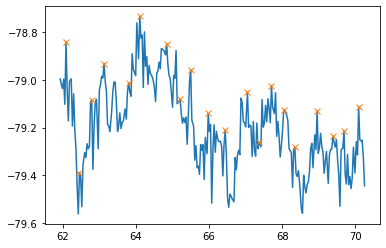

20
2.4039206399169544


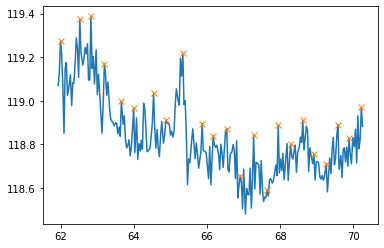

23
2.7645087359044975


In [210]:
X_=processing_jade(data)
print("before JADE...")
for i in range(3):
    plt.plot(X[i][:]-np.mean(X[i][:]))
#     count_peaks(-X[i])
plt.show()

count_peaks(-X[0])
count_peaks(-X[1])
count_peaks(X[2])

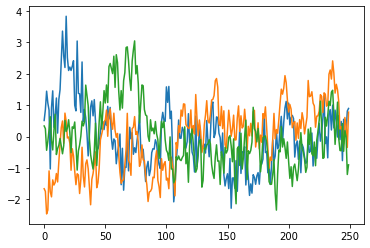

In [211]:
for i in range(3):
    plt.plot(X_[i][:]-np.mean(X_[i][:]))

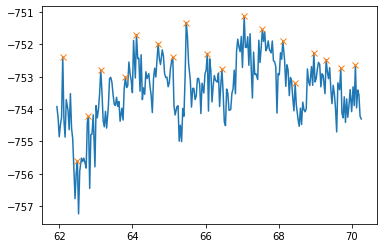

19
2.2837246079211067


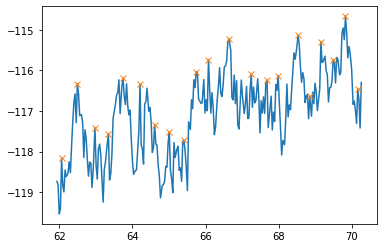

21
2.524116671912802


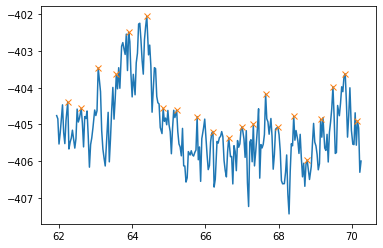

21
2.524116671912802


In [212]:
count_peaks(-X_[0])
count_peaks(X_[1],5)
count_peaks(X_[2])

## detrending

In [213]:
from scipy import sparse
from scipy.sparse import spdiags

def detrending(z,lam=10):
    T = len(z)
    I = sparse.eye(T).toarray()
    data_ = np.ones((T-2,1)).dot(np.array([[1,-2,1]]))
    diags=np.array([0,1,2])
    D2 = spdiags(data_.T, diags, T-2, T)
    z_stat = (I-np.linalg.inv(I + lam*lam * D2.T.dot(D2))).dot(z)
    z_stat = np.array(z_stat)[0]
    return z_stat

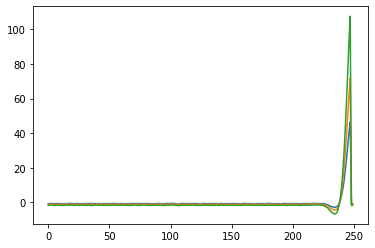

In [214]:
detrended = [[],[],[]]
for i in range(3):
    detrended[i] = detrending (X[i])
for i in range(3):
    plt.plot(detrended[i][:]-np.mean( detrended[i][:]))
detrended=np.array(detrended)

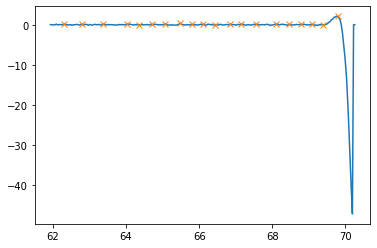

20
2.4039206399169544


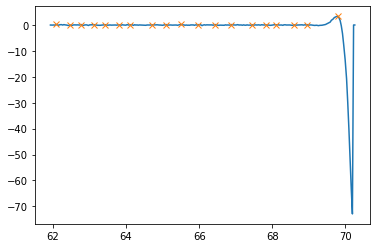

19
2.2837246079211067


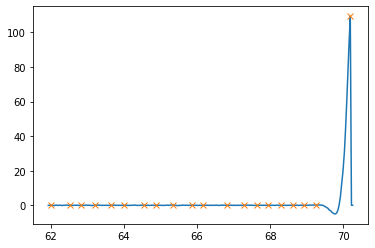

20
2.4039206399169544


In [215]:
count_peaks(-detrended[0])
count_peaks(-detrended[1])
count_peaks(detrended[2])

## applying PCA

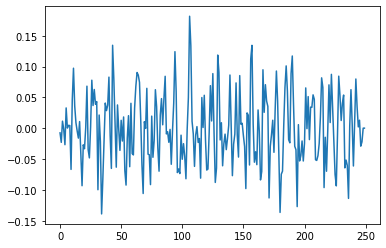

In [216]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(detrended.T)
transformed = pca.transform(detrended.T)
extracted = transformed.T[1]
plt.plot(extracted)
# plt.plot(detrended[0])

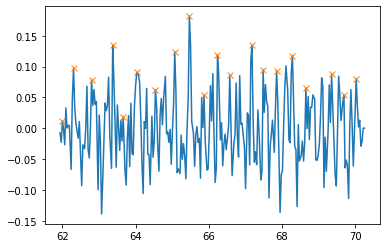

20
2.4039206399169544


In [217]:
count_peaks(extracted)

## BP filter

In [218]:
from scipy.signal import butter, lfilter
import numpy as np

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

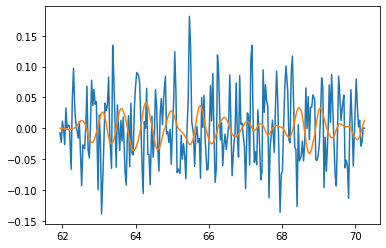

In [219]:
# for i in range(3):
#     y = butter_bandpass_filter(detrended[i], 0.8, 6, 100, 4)
#     plt.figure(2)
#     plt.clf()
#     plt.plot(data[0], detrended[i], label='Noisy signal')
#     plt.plot(data[0], y, label='Filtered signal')
#     plt.show()
#     print(find_argmax([data[0],y]))


y = butter_bandpass_filter(extracted, 0.8, 6, 100, 4)
plt.plot(data[0], extracted, label='Noisy signal')
plt.plot(data[0], y, label='Filtered signal')

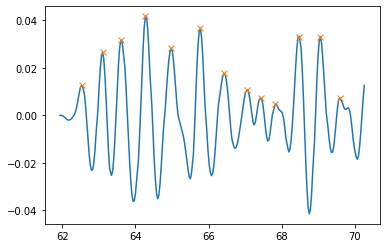

13
1.5625484159460203


In [220]:
count_peaks(y)

## get the frequency with fft

In [221]:
def find_argmax(data, start = 0, do_plot = True,f_s=1):
    times = data[0]
    color = data[1]
    L = len(data[0])
    f_s=L
    even_times = np.linspace(times[0], times[-1], L)
    interpolated = np.interp(even_times, times, color)
    interpolated = np.hamming(L) * interpolated  # a wave with width L * interpolated value
    interpolated = interpolated - np.mean(interpolated)  # standardisation?
    raw = np.fft.rfft(interpolated)
    peak = np.abs(raw)

    freqs = np.fft.rfftfreq(len(times))*f_s/(times[-1]-times[0])*60
    # freqs = float(fps) / L * np.arange(L / 2 + 1) *60
    # print(freqs)
    
    k=start
    
    if do_plot:   
        fig, ax=plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("frequency domain")
        ax.stem(freqs[k:],np.abs(raw[k:]))
#     print(np.argmax(peak[k:]))
#     print(freqs[k+np.argmax(peak[k:])])
          
    return freqs[k+np.argmax(peak[k:])]

C:\Users\yexue\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


90.9111480547855

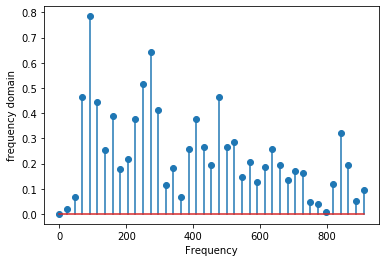

In [226]:
# find_argmax([data[0],y])
find_argmax([data[0][20:100],extracted[20:100]])

C:\Users\yexue\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


<StemContainer object of 3 artists>

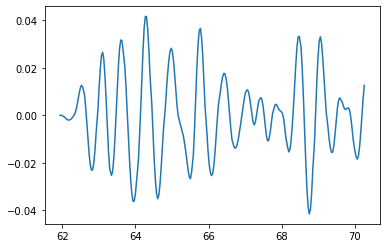

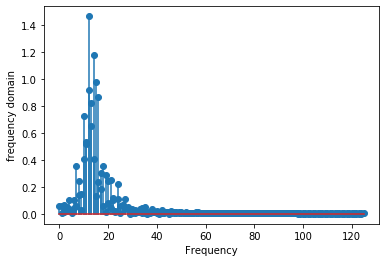

In [223]:
from scipy import fftpack

f=10 #frequency = frequency domain
f_s=100 # 采样率

t=np.linspace(2, 4, 2*f_s, endpoint=False)
x=np.sin(f *2*np.pi*t) #sin(20*2 pi t)
# print(len(t))

f_s=len(data[0])
x=y
t=data[0]
fig, ax=plt.subplots()
ax.plot(t,x)

X = fftpack.rfft(x)
# print(len(x),f_s)
freqs=fftpack.rfftfreq(len(x))*f_s
# print(freqs)
#np.abs(X)
fig, ax=plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("frequency domain")
ax.stem(freqs,np.abs(X))